# Text Classification  
  
O objetivo deste notebook é fazer um estudo sobre a classificação de textos. Serão usadas diversas técnicas para criar um modelo que classifique resumos de teses de doutorado e dissertação de mestrado. Serão usados documentos elaborados por técnicos da Petrobras e outros pertencentes a domínios opostos ao que se é pesquisado na companhia. Esperamos que os modelos classifiquem corretamente os documentos nos seus respectivos domínios.
  
Baseado no post de Shivam Bansa, consultado em 14/08/2019 em:  
Bansal, S., 2018. A Comprehensive Guide to Understand and Implement Text Classification in Python. Analytics Vidhya. URL https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/ (accessed 8.14.19).

In [1]:
# Importando bibliotecas
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from random import shuffle
import pandas as pd
import numpy as np
import xgboost, textblob, string
from keras.preprocessing import text, sequence
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Concatenate
from keras.layers import Layer
from keras.layers import Flatten
import tensorflow as tf
from keras.initializers import get
from bs4 import BeautifulSoup as bs
import nltk
from  nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from langdetect import detect
from langdetect import detect_langs

Using TensorFlow backend.


# Preparando os dados

Lendo arquivos JSON com os dados das teses Petrobras no BDTD, das teses no BDTD com assunto "Petroleo" e teses de assunto opostos ao de interesse Petrobras ("Linguas, Letras e Artes", "Arqueologia", "Demografia", ...)

In [2]:
teses_Subject_petroleo = pd.read_json('BDTD/New_Subject_petroleo.json', orient = 'index')
teses_petrobras_BDTD = pd.read_json('Petrobras/New_teses_petrobras_BDTD.json', orient = 'index')
tese_mesma_area_Large = pd.read_json('BDTD/teses_mesmas_areas_Large.json', orient = 'index')
teses_areas_opostas_Large = pd.read_json('BDTD/teses_areas_opostas_Large.json', orient = 'index')

In [3]:
# Número total de documentos
len(tese_mesma_area_Large) + len(teses_areas_opostas_Large)

11532

In [4]:
# Unindo as teses de Petróleo 
teses_petroleo = teses_Subject_petroleo
teses_petroleo = teses_petroleo.append(teses_petrobras_BDTD)
# Excluindo teses duplicadas
teses_petroleo = teses_petroleo[~teses_petroleo.index.duplicated(keep='first')]

In [5]:
# Unindo as teses de todas as áreas 
teses_areas = tese_mesma_area_Large
teses_areas = teses_areas.append(teses_areas_opostas_Large)
# Excluindo teses duplicadas
teses_areas = teses_areas[~teses_areas.index.duplicated(keep='first')]

Acrescentando a classe nos dois DataFrame

In [6]:
teses_petroleo['classe'] = 'Petroleo'
teses_areas ['classe'] = 'Todas Areas'

Verificando a existência de teses duplicadas nas duas classes

In [7]:
# Unindo as duas classes de documentos
todos = teses_petroleo
todos = todos.append(teses_areas)
len(todos)

13885

In [16]:
# Verificando a existência de documentos doplicados
todos = todos[~todos.index.duplicated(keep='first')]
len(todos)

13845

In [8]:
#SEparando novamente
teses_petroleo = todos[todos['classe'] == 'Petroleo']
teses_areas = todos[todos['classe'] == 'Todas Areas']

Verificando balanceamento das duas classes

In [9]:
print ('teses_petroleo: ', len(teses_petroleo))
print ('teses_areas: ', len(teses_areas))

teses_petroleo:  2366
teses_areas:  11519


Verificando os campos de resumo

In [10]:
# Excluindo documentos sem resumo em português
teses_petroleo = teses_petroleo[(teses_petroleo['Resumo Português:'].notnull())]
teses_areas = teses_areas[(teses_areas['Resumo Português:'].notnull())]

In [11]:
# Função que recebe um texto e separa a parte português da parte em inglês
def separacao_port_engl(abstract):
    
    # Tokeniza os resumos em sentenças 
    mix_sent = nltk.sent_tokenize(abstract)
    
    # Algumas sentenças vem unidas sem espaço. 
    # Portanto é necessário encontra o ponto final para quebrar a sentença em duas.
    new_mix = []
    for sent in mix_sent:
        position = sent.find('.')
        if position != len(sent)-1:
            sent_1 = sent[:position+1]
            sent_2 = sent[position+1:]
            new_mix.append(sent_1)
            new_mix.append(sent_2)
        else:
            new_mix.append(sent)

    mix_sent = new_mix
    
    # Para cada sentença, identificar se ela está em português ou inglês
    port = []
    engl = []

    for sent in mix_sent:
        try:
            if detect (sent) == 'pt':
                port.append(sent)
            else:
                engl.append (sent)
        except:
            pass
    
    # As sentenças são unidas novamente
    port = " ".join(port)
    engl = " ".join(engl)

    # A função retorna os resumos em cada idioma
    return(port, engl)

In [ ]:
# Separando português e inglês para teses petróleo
columns_pt = teses_petroleo['Resumo Português:'].apply(lambda x: separacao_port_engl(x)[0])
columns_en = teses_petroleo['Resumo Português:'].apply(lambda x: separacao_port_engl(x)[1])
teses_petroleo['Resumo Português:'] = columns_pt
teses_petroleo['Resumo inglês 2:'] = columns_en

# Separando português e inglês para teses das demais áreas
columns_pt = teses_areas['Resumo Português:'].apply(lambda x: separacao_port_engl(x)[0])
columns_en = teses_areas['Resumo Português:'].apply(lambda x: separacao_port_engl(x)[1])
teses_areas['Resumo Português:'] = columns_pt
teses_areas['Resumo inglês 2:'] = columns_en

Excluindo novamente as teses sem resumo em portugues

In [ ]:
teses_petroleo = teses_petroleo[(teses_petroleo['Resumo Português:'].notnull())]
teses_areas = teses_areas[(teses_areas['Resumo Português:'].notnull())]

Preprocessando o texto e retirando stopwords

In [ ]:
# Letras em minúsculas
teses_petroleo['Resumo Português:'] = teses_petroleo['Resumo Português:'].str.lower()
teses_areas['Resumo Português:'] = teses_areas['Resumo Português:'].str.lower()

In [ ]:
# Preprocessando os textos
teses_mesmas_areas_Large['Resumo Português:'] = (teses_mesmas_areas_Large['Resumo Português:'].apply(gensim.utils.simple_preprocess)
                                                 .str.join(" "))
tese_area_oposta_Large['Resumo Português:'] = (tese_area_oposta_Large['Resumo Português:'].apply(gensim.utils.simple_preprocess)
                                               .str.join(" "))

In [ ]:
# Importando as bibliotecas de stopwords
nltk.download('stopwords')

# Mapeando stopwords com NLTK
stopwordsIngles = stopwords.words("portuguese")

def remove_stopwords(abstract):
    without_stopwords = []
    for word in abstract:
        if word not in stopwordsIngles:
            without_stopwords.append(word)
    return(without_stopwords)
    
# Excluindo stopwords
teses_mesmas_areas_Large['Resumo Português:'] = teses_mesmas_areas_Large['Resumo Português:'].apply(remove_stopwords)
tese_area_oposta_Large['Resumo Português:'] = tese_area_oposta_Large['Resumo Português:'].apply(remove_stopwords)

# Unindo novamente o texto em uma única string
teses_mesmas_areas_Large['Resumo Português:'] = teses_mesmas_areas_Large['Resumo Português:'].str.join(" ")
tese_area_oposta_Large['Resumo Português:'] = tese_area_oposta_Large['Resumo Português:'].str.join(" ")

In [ ]:
# Gravando textos preprocessados em um arquivo JSON
teses_petroleo.to_json('BDTD/tese_petroleo_processada.json', orient = 'index')
teses_areas.to_json('BDTD/tese_areas_processada.json', orient = 'index')

## Dividindo o conjunto de treino, validação e de teste  
  
Vamos dividir os dados em 80% treino e 20% teste

In [25]:
#Função que recebe um dataframe com as teses e retorna dois dataframes com dados de treino e teste.
#'train' é a fração dos dados para treino, o restante é para teste
def train_test(teses, train):
    corte_train = int(round((len(teses)*train),0))
    teses = teses.sample(frac=1)
    teses_train = teses[:corte_train]
    teses_test = teses[corte_train:]
    return(teses_train, teses_test)

In [26]:
# Os documentos são balanceados para ficarem com a mesma quantidades
teses_areas = teses_areas.sample(len(teses_petroleo))

In [27]:
print(len(teses_areas))
print(len(teses_petroleo))

2121
2121


In [28]:
# São separadas as frações para treino e teste
teses_petroleo_train, teses_petroleo_test = train_test(teses_petroleo, 0.8)
teses_areas_train, teses_areas_test = train_test(teses_areas, 0.8)

In [29]:
# Os dados de treino e teste são unindos e embaralhados
# Train
tese_train = teses_petroleo_train
tese_train = tese_train.append(teses_areas_train)
tese_train = tese_train.sample(frac=1).reset_index(drop=True)

#Test
tese_test = teses_petroleo_test
tese_test = tese_test.append(teses_areas_test)
tese_test = tese_test.sample(frac=1).reset_index(drop=True)

In [30]:
# Separando apenas os texto e classes para treinar os classificadores
train_x = tese_train['Resumo Português:']
train_y = tese_train['classe']

test_x = tese_test['Resumo Português:']
test_y = tese_test['classe']

In [31]:
# Codigficando as classes para as variáveis 0 e 1 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y  = encoder.transform(test_y)

In [32]:
print ('Petrobras = ', encoder.transform(['Petroleo'])[0])
print ('Outro = ', encoder.transform(['Todas Areas'])[0])

Petrobras =  0
Outro =  1


# Feature Engineering

The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.  
  
2.1 Count Vectors as features  
2.2 TF-IDF Vectors as features  
* Word level  
* N-Gram level  
* Character level  
  
2.3 Word Embeddings as features  
2.4 Text / NLP based features  
2.5 Topic Models as features  
  
Lets look at the implementation of these ideas in detail.

** 2.1 Count Vectors as features **  
Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [33]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(tese_train['Resumo Português:'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xtest_count =  count_vect.transform(test_x)

**2.2 TF-IDF Vectors as features**  
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.  
  
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
  
TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)
  
**a. Word Level TF-IDF :** Matrix representing tf-idf scores of every term in different documents  
**b. N-gram Level TF-IDF :** N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams  
**c. Character Level TF-IDF :** Matrix representing tf-idf scores of character level n-grams in the corpus

In [34]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(tese_train['Resumo Português:'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(tese_train['Resumo Português:'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(tese_train['Resumo Português:'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_x) 

**2.3 Word Embeddings**  
A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec. Any one of them can be downloaded and used as transfer learning. One can read more about word embeddings here.  
  
Following snnipet shows how to use pre-trained word embeddings in the model. There are four essential steps:  
* Loading the pretrained word embeddings
* Creating a tokenizer object
* Transforming text documents to sequence of tokens and pad them
* Create a mapping of token and their respective embeddings

### implementar word2vec

In [35]:
corpus = todos['Resumo Português:']
corpus = corpus.str.cat(sep=' ')

In [36]:
corpus = nltk.sent_tokenize(corpus) # this gives us a list of sentences
shuffle(corpus)

In [37]:
corpus_processado = []
for sentence in corpus:
    corpus_processado.append(word_tokenize(sentence))

In [38]:
BDTD_word2vec_50 = Word2Vec(corpus_processado, size=50, window=10, min_count=1, workers=4, iter=100)

In [39]:
BDTD_word2vec_50.wv['água']

array([ 7.12968111e-01,  3.46166062e+00,  2.06053996e+00,  4.39700603e+00,
       -3.50624704e+00,  3.31800163e-01,  8.33991468e-01,  1.10308895e+01,
       -2.66259146e+00,  1.27602899e+00, -8.82496357e+00,  7.77490377e+00,
        3.96843147e+00,  6.44058704e+00, -5.84864473e+00, -2.93155837e+00,
        3.90204638e-01,  2.20078611e+00, -4.89421278e-01,  5.52617121e+00,
        7.40845728e+00, -3.94699192e+00, -5.65770328e-01,  7.91462564e+00,
        1.23522739e+01,  6.60260720e-03,  5.72271061e+00,  2.17750311e+00,
        4.86355424e-02,  2.93532109e+00,  2.79215693e+00, -1.34899354e+00,
        6.56379032e+00,  4.31629467e+00,  9.29356217e-01, -2.55792093e+00,
        6.40034342e+00,  2.15267286e-01,  3.87648749e+00, -5.14307833e+00,
        2.26318336e+00, -7.52153730e+00, -3.14844823e+00, -8.52907717e-01,
        7.74169922e-01,  7.74909854e-01, -2.08921123e+00, -1.03366356e+01,
       -3.36383402e-01, -1.67271316e+00], dtype=float32)

In [40]:
BDTD_word2vec_50.wv.similar_by_word('água')

[('vazão', 0.707801103591919),
 ('areia', 0.7072885632514954),
 ('óleo', 0.7007429599761963),
 ('ozônio', 0.6986643671989441),
 ('ar', 0.6920167803764343),
 ('chuva', 0.687802791595459),
 ('solo', 0.6813691854476929),
 ('salinidade', 0.6786234974861145),
 ('umidade', 0.6778683066368103),
 ('peixe/litro', 0.6747674942016602)]

In [67]:
# Save or Import Embedding trained model
BDTD_word2vec_50.save("Embeddings\BDTD_word2vec_50")
#BDTD_word2vec_300 = Word2Vec.load("Embeddings\BDTD_word2vec_300")

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [42]:
# Indexando as palavras presentes no modelo Word2Vec
word2index = {}
for index, word in enumerate(BDTD_word2vec_50.wv.index2word):
    word2index[word] = index

In [43]:
# Indexando as palavras presentes no modelo Word2Vec
word2index = {}
for index, word in enumerate(BDTD_word2vec_50.wv.index2word):
    word2index[word] = index
    
# Função para indexar o texto usando os índices do modelo Word2Vec
def index_pad_text(text, maxlen, word2index):
    maxlen = 400
    new_text = [] 
    for sent in text:
        temp_sent = []
        for word in word_tokenize(sent):
            try:
                temp_sent.append(word2index[word])
            except:
                pass
        # Estebelecendo um limite máximo de palavras para cada resumo (padding)
        if len(temp_sent) > maxlen:
            temp_sent = temp_sent[:400]
        else:
            temp_sent += [0] * (maxlen - len(temp_sent))
        new_text.append(temp_sent)

    return np.array(new_text)

maxlen = 400
train_seq_x = index_pad_text(train_x, maxlen, word2index)
test_seq_x = index_pad_text(test_x, maxlen, word2index)

In [44]:
word2index['estudamos']

7690

In [45]:
test_x[2]

'o consumo crescente da utilização de combustíveis fósseis, sobretudo do diesel, como fonte energética para o setor de transporte traz uma preocupação ambiental no que diz respeito às emissões de gases poluentes. paralelamente a este cenário, cresce o número de pesquisas para desenvolvimento de biocombustíveis, que são considerados como uma alternativa mais limpa, visto que são oriundos de fontes renováveis e considerados como menos poluentes que o óleo diesel. o biodiesel representa um tipo de biocombustível, capaz de gerar energia a partir de fontes renováveis, mas que apresenta a grande problemática de formação de grandes volumes de glicerina, que acabam gerando um produto em excedente no mercado, que ainda não consegue absorver toda a produção gerada. estudou-se nesse trabalho através da construção de seus respectivos diagramas de fases o comportamento das fases de seis sistemas, a temperatura de 25°c e pressão de 1 atm,. sendo o sistema i (diesel / solução 15% de glicerina / mistu

In [46]:
test_seq_x[2]

array([     5,    243,   1266,      8,    207,      1,   1984,   7052,
            0,   1549,      7,   1468,      0,     25,    652,   1759,
           15,      5,    465,      1,    879,   2909,     23,   2108,
          395,     20,     12,   1867,    625,    105,   2592,      1,
         1727,   2538,      2,  14155,      4,    134,    873,      0,
         8963,      5,    194,      1,    676,     15,     85,      1,
        10977,      0,     12,     55,   1066,     25,     23,    711,
           46,   9575,      0,   1417,     12,     55,   3105,      1,
          606,   5751,      3,   1066,     25,    493,   2538,     12,
            5,    172,   1468,      2,      5,   1398,   1205,     24,
          163,      1,  17149,      0,    681,      1,   1881,    266,
            4,     74,      1,    606,   5751,      0,    227,     12,
          210,      4,    170,   3793,      1,    171,      1,    680,
         2166,      1,   3596,      0,     12,   9562,   2588,     24,
      

**2.4 Text / NLP based features**  
A number of extra text based features can also be created which sometimes are helpful for improving text classification models. Some examples are:  
  
1 Word Count of the documents – total number of words in the documents  
2 Character Count of the documents – total number of characters in the documents  
3 Average Word Density of the documents – average length of the words used in the documents  
4 Puncutation Count in the Complete Essay – total number of punctuation marks in the documents  
5 Upper Case Count in the Complete Essay – total number of upper count words in the documents  
6 Title Word Count in the Complete Essay – total number of proper case (title) words in the documents  
7 Frequency distribution of Part of Speech Tags:  
* Noun Count  
* Verb Count  
* Adjective Count
* Adverb Count
* Pronoun Count
  
These features are highly experimental ones and should be used according to the problem statement only.

In [34]:
tese_train['char_count'] = tese_train['Resumo Português:'].apply(len)
tese_train['word_count'] = tese_train['Resumo Português:'].apply(lambda x: len(x.split()))
tese_train['word_density'] = tese_train['char_count'] / (tese_train['word_count']+1)
tese_train['punctuation_count'] = (tese_train['Resumo Português:'].
                                   apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))) 
tese_train['title_word_count'] = (tese_train['Resumo Português:'].
                                  apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])))
tese_train['upper_case_word_count'] = (tese_train['Resumo Português:'].
                                       apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()])))

**Accessing the MacMorpho Tagged Corpus**  
NLTK includes the MAC-MORPHO Brazilian Portuguese POS-tagged news text, with over a million words of journalistic texts extracted from ten sections of the daily newspaper Folha de Sao Paulo, 1994.
  
We can access this corpus as a sequence of words or tagged words as follows:

In [35]:
import nltk.corpus
#nltk.download('mac_morpho')
nltk.corpus.mac_morpho.words()
#['Jersei', 'atinge', 'm\xe9dia', 'de', 'Cr$', '1,4', ...]
nltk.corpus.mac_morpho.sents() # doctest: +NORMALIZE_WHITESPACE
#[['Jersei', 'atinge', 'm\xe9dia', 'de', 'Cr$', '1,4', 'milh\xe3o',
#'em', 'a', 'venda', 'de', 'a', 'Pinhal', 'em', 'S\xe3o', 'Paulo'],
#['Programe', 'sua', 'viagem', 'a', 'a', 'Exposi\xe7\xe3o', 'Nacional',
#'do', 'Zebu', ',', 'que', 'come\xe7a', 'dia', '25'], ...]
nltk.corpus.mac_morpho.tagged_words()
#[('Jersei', 'N'), ('atinge', 'V'), ('m\xe9dia', 'N'), ...]
nltk.corpus.mac_morpho.tagged_sents()[100]

[('Bezerra', 'NPROP'),
 ('diz', 'V'),
 ('que', 'KS'),
 ('está', 'VAUX'),
 ('articular', 'V'),
 ('uma', 'ART'),
 ('ação', 'N'),
 ('conjunta', 'ADJ'),
 ('de', 'PREP|+'),
 ('o', 'ART'),
 ('com', 'PREP'),
 ('os', 'ART'),
 ('governos', 'N'),
 ('de', 'PREP|+'),
 ('os', 'ART'),
 ('três', 'NUM'),
 ('Estados', 'N'),
 ('para', 'PREP'),
 ('controlar', 'V'),
 ('a', 'ART'),
 ('praga', 'N')]

**Accessing the Floresta Portuguese Treebank**  
The NLTK data distribution includes the "Floresta Sinta(c)tica Corpus" version 7.4, available from http://www.linguateca.pt/Floresta/.
  
We can access this corpus as a sequence of words or tagged words as follows:

In [36]:
from nltk.corpus import floresta
floresta.words()
floresta.tagged_words()

[('Um', '>N+art'), ('revivalismo', 'H+n'), ...]

The tags consist of some syntactic information, followed by a plus sign, followed by a conventional part-of-speech tag. Let's strip off the material before the plus sign:

In [37]:
def simplify_tag(t):
    if "+" in t:
        return t[t.index("+")+1:]
    else:
        return t
twords = floresta.tagged_words()
twords = [(w.lower(), simplify_tag(t)) for (w,t) in twords]
twords[:10]
#[('um', 'art'), ('revivalismo', 'n'), ('refrescante', 'adj'), ('o', 'art'), ('7_e_meio', 'prop'),
#('\xe9', 'v-fin'), ('um', 'art'), ('ex-libris', 'n'), ('de', 'prp'), ('a', 'art')]

[('um', 'art'),
 ('revivalismo', 'n'),
 ('refrescante', 'adj'),
 ('o', 'art'),
 ('7_e_meio', 'prop'),
 ('é', 'v-fin'),
 ('um', 'art'),
 ('ex-libris', 'n'),
 ('de', 'prp'),
 ('a', 'art')]

**Part-of-Speech Tagging**

In [38]:
# Let's begin by getting the tagged sentence data, and simplifying the tags as described earlier.
tsents = floresta.tagged_sents()
tsents = [[(w.lower(),simplify_tag(t)) for (w,t) in sent] for sent in tsents if sent]
train = tsents[1000:]
test = tsents[:1000]

In [39]:
#We already know that n is the most common tag, so we can set up a default tagger that tags every word as a noun, and see how well it does:
tagger0 = nltk.DefaultTagger('n')
print ('tagger0 (every word noun) = ', tagger0.evaluate(test))
#nltk.tag.api.evaluate(tagger0, test)
#0.17697228144989338

#Evidently, about one in every six words is a noun. Let's improve on this by training a unigram tagger:
tagger1 = nltk.UnigramTagger(train, backoff=tagger0)
print('tagger1 - Unigram = ', tagger1.evaluate(test))
#nltk.tag.accuracy(tagger1, test)
#0.87029140014214645

#Next a bigram tagger:
tagger2 = nltk.BigramTagger(train, backoff=tagger1)
print('tagger2 Bigram = ', tagger2.evaluate(test))
#nltk.tag.accuracy(tagger2, test)
#0.89019189765458417

tagger0 (every word noun) =  0.17800040072129833
tagger1 - Unigram =  0.8740532959326788
tagger2 Bigram =  0.8900420757363254


In [40]:
pos_family = {
    'noun' : ['n'],
    'adj' :  ['adj'],
    'art' : ['art'],
    'pron' : ['pron-det', 'pron-indp', 'pron-pers', 'prop'],
    'num': ['num'],
    'verb' : ['v-fin','v-ger', 'v-inf', 'v-pcp'],
    'adv' : ['adv'],
    'prp': ['prp'],
    'conj' : ['conj-c', 'conj-s'],
    'in' : ['in'],
    'ec' : ['ec']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        for tup in tagger2.tag(x):
            if tup[1] in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

tese_train['noun_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'noun'))
tese_train['adj_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'adj'))
tese_train['art_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'art'))
tese_train['pron_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'pron'))
tese_train['num_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'num'))
tese_train['verb_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'verb'))
tese_train['adv_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'adv'))
tese_train['prp_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'prp'))
tese_train['conj_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'conj'))
tese_train['in_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'in'))
tese_train['ec_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'ec'))

In [41]:
tese_train.head()

,Assuntos em Inglês:,Assuntos em Portugês:,Autor/a:,Banca:,Citação:,Co-advisor:,Data de Defesa:,Departamento:,Download Texto Completo:,Idioma:,...,adj_count,art_count,pron_count,num_count,verb_count,adv_count,prp_count,conj_count,in_count,ec_count
0,"[Eletric stimulation therapy, Interferential c...","[Fisiologia, Eletroterapia, Correntes elétrica...","\n\n Cruz, Kamilla Mayara Lucas da\n\n",NaN,"CRUZ, Kamilla Mayara Lucas da. O efeito antino...",NaN,2014,NaN,https://ri.ufs.br/handle/riufs/3981,por,...,186,186,308,0,0,0,247,183,0,0
1,[scalle free lattice],[rede sem escala],"\n\n Batista, Carlos Adalberto Schnaide...","\n\n Viana, Ricardo Luiz\n\n, \n\n ...","BATISTA, Carlos Adalberto Schnaider. Sincroniz...",NaN,2007,\nFisica\n\n,http://tede2.uepg.br/jspui/handle/prefix/913,por,...,63,99,177,0,3,0,106,134,4,0
2,"[Reproduction, Testicular morphometry, Ouratea...","[Reprodução, Morfometria testicular, Raiz de b...","\n\n Matta, Ana Paula de Lima Florentin...","\n\n Neves, Clóvis Andrade\n\n, \n\n ...","MATTA, Ana Paula de Lima Florentino. Effects o...","\n\n Leite, João Paulo Viana\n\n, \n\n ...",2008,\nAnálises quantitativas e moleculares do Geno...,http://locus.ufv.br/handle/123456789/2307,por,...,93,172,286,0,2,0,153,181,10,0
3,"[Migration, Life quality, Federal servers]","[Emigração, Qualidade de vida, Servidores públ...","\n\n Francisco, Arnaldo\n\n","\n\n Silva, Douglas Mansur da\n\n, \n\n...","FRANCISCO, Arnaldo. Migration and life quality...","\n\n Loreto, Maria das Dores Saraiva de...",2011,\nEconomia familiar; Estudo da família; Teoria...,http://locus.ufv.br/handle/123456789/3336,por,...,215,231,518,0,3,0,318,305,6,0
4,"[Culicid, Intraspecific, Competition, Size, Diet]","[Culicídeo, Intraespecífica, Competição, Taman...","\n\n Felchicher, Francielly",NaN,"FELCHICHER, Francielly. Influência da densidad...","\n\n Vianna, Élvia Elena Silveira\n\n",2013,\nBiologia\n\n,http://repositorio.ufpel.edu.br/handle/ri/2333,por,...,144,181,321,0,3,0,228,204,5,0


**2.5 Topic Models as features**  
Topic Modelling is a technique to identify the groups of words (called a topic) from a collection of documents that contains best information in the collection. I have used Latent Dirichlet Allocation for generating Topic Modelling Features. LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents. One can read more about topic modelling here

In [42]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=30, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [43]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [44]:
topic_summaries

['gi vd ta pupas sitos officinalis polifenóis ractopamina carv iatf',
 'grupo grupos corporal animais controle sm risco exercício gordura arterial',
 'leprosy ndo lid ufrpe bas tocolytic nthf enxerto emáx hsa',
 'embriões wind oócitos bcl logos gli tca part descartado laminado',
 'vs alimenta respiratórios bode sgrq tático espirometria breathing volume snip',
 'de do da os com que em para no as',
 'the of and in to with for de was that',
 'materiais resistência material propriedades ensaios dental mecânicas tração compósitos mm',
 'la el en los de las del le eu un',
 'festa lv atletas memória kt sedentário vl festas cpt inspeção',
 'dys cateter aflatoxinas enteritidis estocagem camarosa filés gmd mr gelo',
 'platensis gos tds bagasse apl ids bai orégano rat imagination',
 'silagens moringa rpaj ensilagem ndt pradj rebrotação artificialmente trematódeo lpa',
 'bacia rio área água região ambiental sub norte hidrográfica eventos',
 'deus gica dança justi jornalismo acústica sica metaf caf

**3. Model Building**  
The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. We will implement following different classifiers for this purpose:  
 
* Naive Bayes Classifier
* Linear Classifier
* Support Vector Machine
* Bagging Models
* Boosting Models
* Shallow Neural Networks
* Deep Neural Networks
* Convolutional Neural Network (CNN)
* Long Short Term Modelr (LSTM)
* Gated Recurrent Unit (GRU)
* Bidirectional RNN
* Recurrent Convolutional Neural Network (RCNN)
* Other Variants of Deep Neural Networks  

Lets implement these models and understand their details. The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed.

In [65]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net=False):
    # fit the training dataset on the classifier
    
    if is_neural_net:
        callbacks = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)
        history = classifier.fit(feature_vector_train,
                                 label, #to_categorical(label),
                                 epochs=1000,
                                 batch_size=64,
                                 validation_split=0.25,
                                 callbacks=[callbacks])
        
    # plot the loss
        # list all data in history
        print(history.history.keys())
        # summarize history for loss
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model acc')
        plt.ylabel('acc')
        plt.xlabel('epoch')
        plt.legend(['acc', 'val_acc'], loc='upper left')
        plt.show()
        
    else:
        classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    predictions = np.rint(predictions)
    
    num_classes = 2
    return (metrics.accuracy_score(predictions, test_y),
            tf.confusion_matrix(predictions, test_y, num_classes),
            classifier)

**3.1 Naive Bayes**  
Implementing a naive bayes model using sklearn implementation with different features  
  
Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature here .

In [55]:
# Naive Bayes on Count Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xtest_count)
print ("NB, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Naive Bayes on Word Level TF IDF Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xtest_tfidf)
print ("NB, WordLevel TF-IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())
    
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())
    
# Naive Bayes on Character Level TF IDF Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

NB, Count Vectors:  0.8738207547169812
[[404  87]
 [ 20 337]]
NB, WordLevel TF-IDF Vectors:  0.8608490566037735
[[392  86]
 [ 32 338]]
NB, N-Gram Vectors:  0.8679245283018868
[[383  71]
 [ 41 353]]
NB, CharLevel Vectors:  0.8490566037735849
[[401 105]
 [ 23 319]]


In [49]:
i = 0
for n in range (len(teses_petroleo)):
    vector = count_vect.transform([teses_petroleo['Resumo Português:'][n]])
    if classifier_NB.predict(vector) != [0]:
        i += 1
        print (teses_petroleo.index[n])
        print('Real: ', teses_petroleo.iloc[n]['classe'])
        #vector = count_vect.transform([teses_petroleo['Resumo Português:'][n]])
        if classifier_NB.predict(vector) == [0]:
            previsto = 'Petroleo'
        else:
            previsto = 'Todas Areas'
        print('Previsto: :', previsto)
        print('Titulo: ', teses_petroleo.iloc[n]['Title'])
        print('Resumo: ', teses_petroleo.iloc[n]['Resumo Português:'])
        print (" ")
print('Número de erros: ', i)

NameError: name 'classifier_NB' is not defined

In [ ]:
todos.index[0]

**3.2 Linear Classifier**  
Implementing a Linear Classifier (Logistic Regression)  
  
Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. One can read more about logistic regression here

In [56]:
# Linear Classifier on Count Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xtest_count)
print ("LR, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Linear Classifier on Word Level TF IDF Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xtest_tfidf)
print ("LR, WordLevel TF-IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Linear Classifier on Character Level TF IDF Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, Count Vectors:  0.9056603773584906
[[382  38]
 [ 42 386]]
LR, WordLevel TF-IDF Vectors:  0.8974056603773585
[[381  44]
 [ 43 380]]
LR, N-Gram Vectors:  0.8891509433962265
[[372  42]
 [ 52 382]]
LR, CharLevel Vectors:  0.8856132075471698
[[379  52]
 [ 45 372]]


**3.3 Implementing a SVM Model**  
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes. One can read more about it here

In [57]:
# SVM on Count Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_count, train_y, xtest_count)
print ("SVM, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# SVM on Word Level TF IDF Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_tfidf, train_y, xtest_tfidf)
print ("SVM, Word Level TF IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# SVM on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("SVM, Ngram Level TF IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# SVM on Character Level TF IDF Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("SVM, Character Level TF IDFs Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

SVM, Count Vectors:  0.8903301886792453
[[375  44]
 [ 49 380]]
SVM, Word Level TF IDF Vectors:  0.9174528301886793
[[389  35]
 [ 35 389]]
SVM, Ngram Level TF IDF Vectors:  0.9044811320754716
[[378  35]
 [ 46 389]]
SVM, Character Level TF IDFs Vectors:  0.9068396226415094
[[385  40]
 [ 39 384]]


**3.4 Bagging Model**  
Implementing a Random Forest Model  
  
Random Forest models are a type of ensemble models, particularly bagging models. They are part of the tree based model family. One can read more about Bagging and random forests here

In [58]:
# RF on Count Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xtest_count)
print ("RF, Count Vectors Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# RF on Word Level TF IDF Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xtest_tfidf)
print ("RF, WordLevel TF-IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# RF on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("RF, Ngram Level TF IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# RF on Character Level TF IDF Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("RF, Character Level TF IDFs Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors Vectors:  0.8584905660377359
[[382  78]
 [ 42 346]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, WordLevel TF-IDF Vectors:  0.8879716981132075
[[390  61]
 [ 34 363]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Ngram Level TF IDF Vectors:  0.8938679245283019
[[393  59]
 [ 31 365]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Character Level TF IDFs Vectors:  0.8608490566037735
[[374  68]
 [ 50 356]]


**3.5 Boosting Model**  
Implementing Xtereme Gradient Boosting Model  
  
Boosting models are another type of ensemble models part of tree based models. Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). Read more about these models here

In [59]:
# Extereme Gradient Boosting on Count Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xtest_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xtest_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Extereme Gradient Boosting on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xtest_tfidf_ngram.tocsc())
print ("Xgb, Ngram Level Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xtest_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

Xgb, Count Vectors:  0.9091981132075472
[[363  16]
 [ 61 408]]
Xgb, WordLevel TF-IDF:  0.9139150943396226
[[364  13]
 [ 60 411]]
Xgb, Ngram Level Vectors:  0.8832547169811321
[[331   6]
 [ 93 418]]
Xgb, CharLevel Vectors:  0.9127358490566038
[[371  21]
 [ 53 403]]


**3.6 Shallow Neural Networks**  
A neural network is a mathematical model that is designed to behave similar to biological neurons and nervous system. These models are used to recognize complex patterns and relationships that exists within a labelled data. A shallow neural network contains mainly three types of layers – input layer, hidden layer, and output layer. Read more about neural networks here

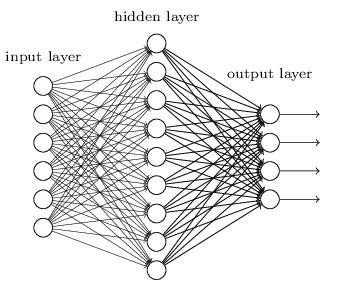

Train on 2545 samples, validate on 849 samples
Epoch 1/1000
2545/2545 [==============================] - 7s 3ms/step - loss: 0.4232 - acc: 0.8153 - val_loss: 0.2841 - val_acc: 0.8834
Epoch 2/1000
2545/2545 [==============================] - 5s 2ms/step - loss: 0.1472 - acc: 0.9599 - val_loss: 0.2373 - val_acc: 0.8963
Epoch 3/1000
2545/2545 [==============================] - 5s 2ms/step - loss: 0.0808 - acc: 0.9851 - val_loss: 0.2214 - val_acc: 0.9081
Epoch 4/1000
2545/2545 [==============================] - 5s 2ms/step - loss: 0.0505 - acc: 0.9917 - val_loss: 0.2164 - val_acc: 0.9093
Epoch 5/1000
2545/2545 [==============================] - 5s 2ms/step - loss: 0.0346 - acc: 0.9925 - val_loss: 0.2119 - val_acc: 0.9093
Epoch 6/1000
2545/2545 [==============================] - 5s 2ms/step - loss: 0.0254 - acc: 0.9980 - val_loss: 0.2080 - val_acc: 0.9211
Epoch 7/1000
2545/2545 [==============================] - 5s 2ms/step - loss: 0.0199 - acc: 0.9984 - val_loss: 0.2097 - val_acc: 0.9187
E

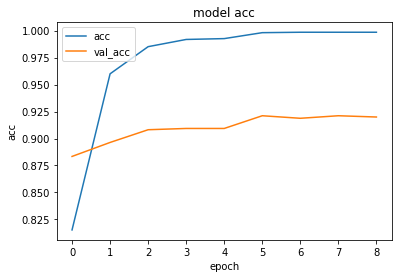

Shallow Neural Network on Count Vectors Vectors 0.9115566037735849
[[395  46]
 [ 29 378]]
Train on 2545 samples, validate on 849 samples
Epoch 1/1000
2545/2545 [==============================] - 2s 803us/step - loss: 0.6667 - acc: 0.6228 - val_loss: 0.6336 - val_acc: 0.8481
Epoch 2/1000
2545/2545 [==============================] - 1s 279us/step - loss: 0.5995 - acc: 0.8385 - val_loss: 0.5801 - val_acc: 0.8492
Epoch 3/1000
2545/2545 [==============================] - 1s 266us/step - loss: 0.5341 - acc: 0.8959 - val_loss: 0.5193 - val_acc: 0.8669
Epoch 4/1000
2545/2545 [==============================] - 1s 266us/step - loss: 0.4699 - acc: 0.8931 - val_loss: 0.4630 - val_acc: 0.8681
Epoch 5/1000
2545/2545 [==============================] - 1s 255us/step - loss: 0.4093 - acc: 0.9045 - val_loss: 0.4123 - val_acc: 0.8775
Epoch 6/1000
2545/2545 [==============================] - 1s 260us/step - loss: 0.3550 - acc: 0.9112 - val_loss: 0.3706 - val_acc: 0.8799
Epoch 7/1000
2545/2545 [===========

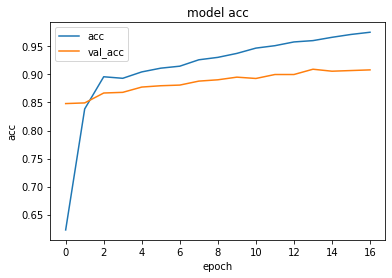

Shallow Neural Network on Word Level TF IDF Vectors 0.8903301886792453
[[393  62]
 [ 31 362]]
Train on 2545 samples, validate on 849 samples
Epoch 1/1000
2545/2545 [==============================] - 2s 702us/step - loss: 0.7256 - acc: 0.5886 - val_loss: 0.6479 - val_acc: 0.7079
Epoch 2/1000
2545/2545 [==============================] - 1s 247us/step - loss: 0.6116 - acc: 0.8177 - val_loss: 0.5928 - val_acc: 0.8528
Epoch 3/1000
2545/2545 [==============================] - 1s 249us/step - loss: 0.5548 - acc: 0.8947 - val_loss: 0.5464 - val_acc: 0.8551
Epoch 4/1000
2545/2545 [==============================] - 1s 247us/step - loss: 0.5011 - acc: 0.8923 - val_loss: 0.4986 - val_acc: 0.8622
Epoch 5/1000
2545/2545 [==============================] - 1s 243us/step - loss: 0.4493 - acc: 0.8939 - val_loss: 0.4536 - val_acc: 0.8645
Epoch 6/1000
2545/2545 [==============================] - 1s 246us/step - loss: 0.4001 - acc: 0.8986 - val_loss: 0.4140 - val_acc: 0.8669
Epoch 7/1000
2545/2545 [=======

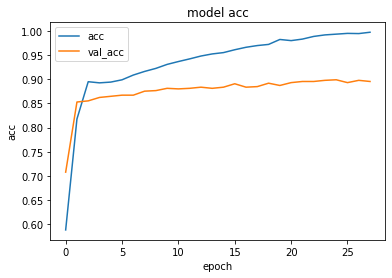

Shallow Neural Network on Ngram Level TF IDF Vectors 0.8915094339622641
[[379  47]
 [ 45 377]]
Train on 2545 samples, validate on 849 samples
Epoch 1/1000
2545/2545 [==============================] - 2s 721us/step - loss: 0.6668 - acc: 0.6739 - val_loss: 0.6321 - val_acc: 0.7585
Epoch 2/1000
2545/2545 [==============================] - 1s 260us/step - loss: 0.5962 - acc: 0.8609 - val_loss: 0.5667 - val_acc: 0.8657
Epoch 3/1000
2545/2545 [==============================] - 1s 263us/step - loss: 0.5309 - acc: 0.8802 - val_loss: 0.5135 - val_acc: 0.8469
Epoch 4/1000
2545/2545 [==============================] - 1s 265us/step - loss: 0.4743 - acc: 0.8754 - val_loss: 0.4561 - val_acc: 0.8681
Epoch 5/1000
2545/2545 [==============================] - 1s 271us/step - loss: 0.4184 - acc: 0.8912 - val_loss: 0.4101 - val_acc: 0.8716
Epoch 6/1000
2545/2545 [==============================] - 1s 259us/step - loss: 0.3727 - acc: 0.8959 - val_loss: 0.3728 - val_acc: 0.8751
Epoch 7/1000
2545/2545 [======

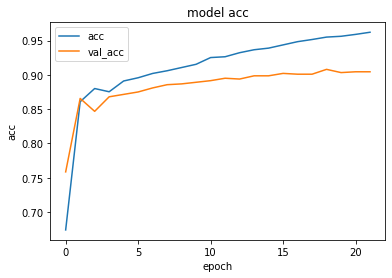

Shallow Neural Network on Character Level TF IDF Vectors 0.9009433962264151
[[389  49]
 [ 35 375]]


In [60]:
def create_model_architecture(input_size):
    # create input layer 
    #input_layer = layers.Input((input_size, ), sparse=True)
    model = Sequential()
    
    # create hidden layer
    model.add(layers.Dense(100,
                           input_shape=(input_size, ),
                           activation="sigmoid"))
    #hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    model.add(layers.Dense(1, activation='sigmoid')) 
    #output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    opt = optimizers.Adam()
    #classifier = models.Model(inputs = input_layer, outputs = output_layer)
    #classifier.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    #model.summary()
    #classifier.summary()
    return model #classifier 

num_classes = 1

# Shallow Neural Network on Count Vectors Vectors
classifier = create_model_architecture(xtrain_count.shape[1])
accuracy, confusion = train_model(classifier, xtrain_count, train_y, xtest_count, is_neural_net=True)
print ("Shallow Neural Network on Count Vectors Vectors",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())


# Shallow Neural Network on Word Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf.shape[1])
accuracy, confusion = train_model(classifier, xtrain_tfidf, train_y, xtest_tfidf, is_neural_net=True)
print ("Shallow Neural Network on Word Level TF IDF Vectors",  accuracy,)
with tf.Session() as sess:
    print(confusion.eval())

# Shallow Neural Network on Ngram Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy, confusion = train_model(classifier, xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram, is_neural_net=True)
print ("Shallow Neural Network on Ngram Level TF IDF Vectors",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())


# Shallow Neural Network on Character Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf_ngram_chars.shape[1])
accuracy, confusion = train_model(classifier, xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars, is_neural_net=True)
print ("Shallow Neural Network on Character Level TF IDF Vectors",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7 Deep Neural Networks**  
Deep Neural Networks are more complex neural networks in which the hidden layers performs much more complex operations than simple sigmoid or relu activations. Different types of deep learning models can be applied in text classification problems.
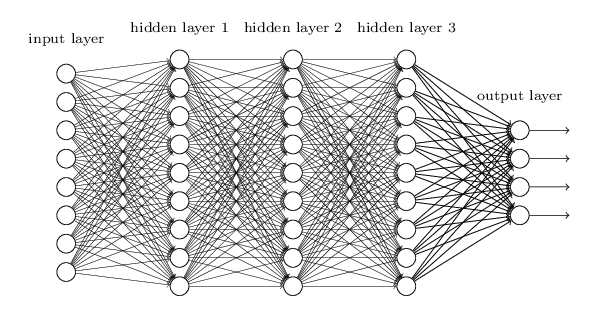

**3.7.1 Convolutional Neural Network**  
In Convolutional neural networks, convolutions over the input layer are used to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. Each layer applies different filters and combines their results.  
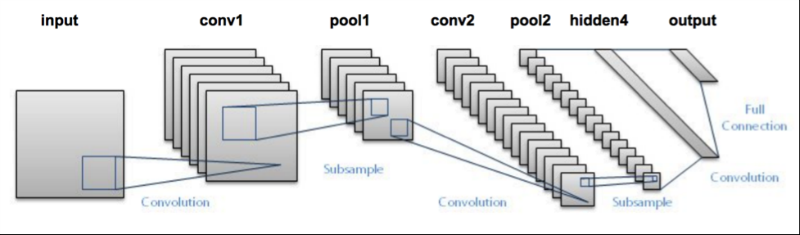

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 400, 50)           9289150   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 400, 50)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 396, 128)          32128     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 198, 128)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 198, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 194, 128)          82048     
__________

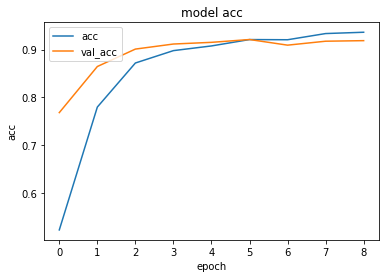

CNN, Word Embeddings 0.9033018867924528
[[368  26]
 [ 56 398]]


In [66]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=False)(input_layer)
    #embedding_layer.mask_zero = True  # No need for a masking layer
    
    
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the convolutional Layer e pooling layer
    conv_layer_1 = layers.Convolution1D(128, 5, activation="relu")(embedding_layer)
    pooling_layer_1 = layers.MaxPooling1D(2)(conv_layer_1)
    pooling_layer_1 = layers.Dropout(0.15)(pooling_layer_1)
    
    conv_layer_2 = layers.Convolution1D(128, 5, activation="relu")(pooling_layer_1)
    pooling_layer_2 = layers.MaxPooling1D(2)(conv_layer_2)
    pooling_layer_2 = layers.Dropout(0.15)(pooling_layer_2)
    
    conv_layer_3 = layers.Convolution1D(128, 5, activation="relu")(pooling_layer_2)
    pooling_layer_3 = layers.GlobalMaxPooling1D()(conv_layer_3)
    pooling_layer_3 = layers.Dropout(0.15)(pooling_layer_3)
    
    # Add the output Layers
    output_layer1 = layers.Dense(512, activation="relu")(pooling_layer_3)
    output_layer2 = layers.Dense(512, activation="relu")(output_layer1)
    output_layer2 = layers.Dropout(0.12)(output_layer2)
    output_layer3 = layers.Dense(1, activation="sigmoid")(output_layer2)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer3)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_cnn()
accuracy, confusion, classifier = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
classifier.save("model_cnn.h5")

print ("CNN, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.2 Recurrent Neural Network – LSTM**  
Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.  
  
The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.  
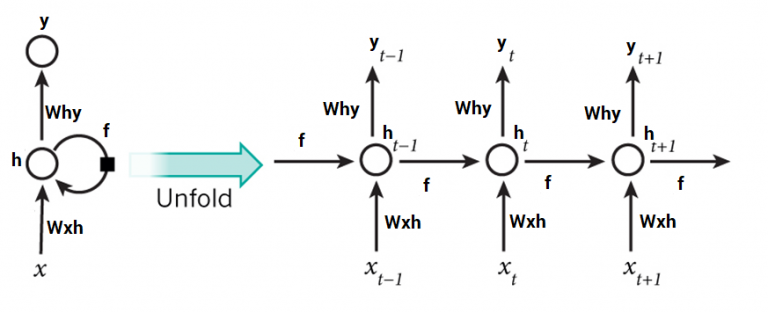


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 50)           9289150   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 400, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 256)          314368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 400, 128)          197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               16640     
__________

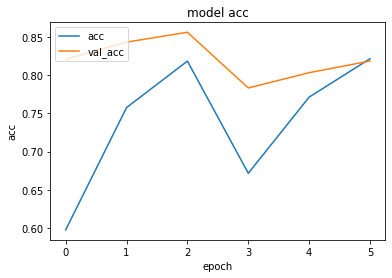

RNN-LSTM, Word Embeddings 0.8254716981132075
[[357  81]
 [ 67 343]]


In [53]:
def create_rnn_lstm():
    
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer_1 = layers.LSTM(256, return_sequences=True)(embedding_layer) #return_sequences=True
    lstm_layer_2 = layers.LSTM(128, return_sequences=True)(lstm_layer_1)
    lstm_layer_3 = layers.LSTM(64)(lstm_layer_2)

    # Add the output Layers
    output_layer1 = layers.Dense(256, activation="relu")(lstm_layer_3)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_rnn_lstm()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.3 Recurrent Neural Network – GRU**  
Gated Recurrent Units are another form of recurrent neural networks. Lets add a layer of GRU instead of LSTM in our network.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 50)           9344700   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 400, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 400, 20)           4260      
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                2460      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                1050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

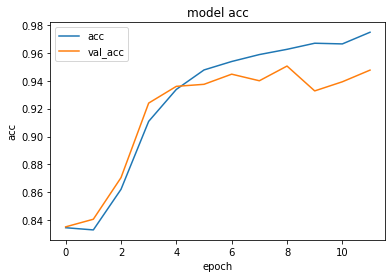

RNN-GRU, Word Embeddings 0.9512550018188433
[[ 364   44]
 [  90 2251]]


In [43]:
def create_rnn_gru():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the GRU Layer
    gru_layer = layers.GRU(20, return_sequences=True)(embedding_layer)
    gru_layer_1 = layers.GRU(20)(gru_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="sigmoid")(gru_layer_1)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_rnn_gru()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-GRU, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.4 Bidirectional RNN**  
RNN layers can be wrapped in Bidirectional layers as well. Lets wrap our GRU layer in bidirectional layer.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 400, 50)           9344700   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 400, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                8520      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total para

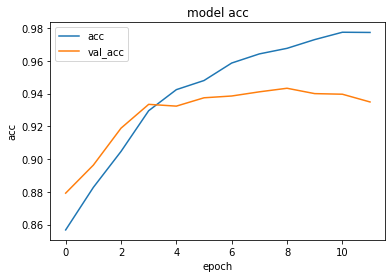

RNN-Bidirectional, Word Embeddings 0.9417970170971263
[[ 358   64]
 [  96 2231]]


In [44]:
def create_bidirectional_rnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.Bidirectional(layers.GRU(20))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_bidirectional_rnn()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.5 Recurrent Convolutional Neural Network**  
Once the essential architectures have been tried out, one can try different variants of these layers such as recurrent convolutional neural network. Another variants can be:  

* Hierarichial Attention Networks
* Sequence to Sequence Models with Attention
* Bidirectional Recurrent Convolutional Neural Networks
* CNNs and RNNs with more number of layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 400, 50)           9344700   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 400, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 398, 100)          15100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________

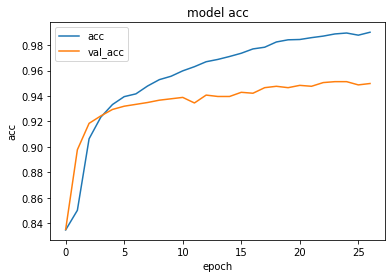

RCNN, Word Embeddings 0.9523463077482721
[[ 367   44]
 [  87 2251]]


In [45]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
 
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="sigmoid")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="sigmoid")(pooling_layer)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_rcnn()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RCNN, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.5 Bidirectional LSTM with attention mechanism** 

You can use the final encoded state of a recurrent neural network for prediction. This could lose some useful information encoded in the previous steps of the sequence. In order to keep that information, you can use an average of the encoded states outputted by the RNN. But all of the encoded states of the RNN are equally valuable. Thus, we are using a weighted sum of these encoded states to make our predicti

In [54]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [69]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

We compute these attention weights simply by building a small fully connected neural network on top of each encoded state. This network will have a single unit final layer which will correspond to the attention weight we will assign.

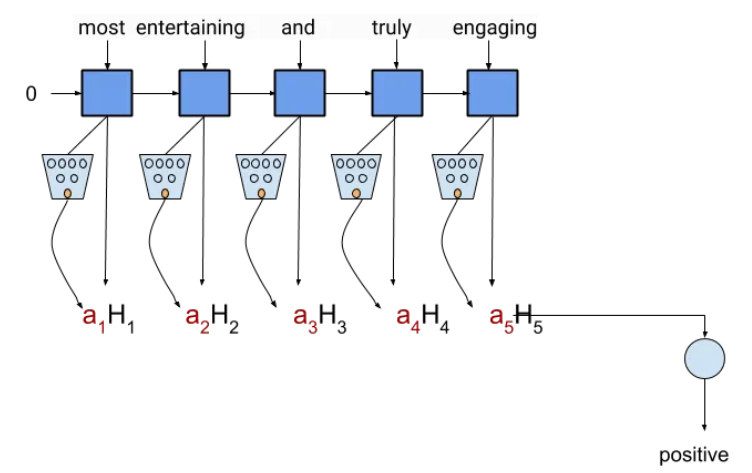

Attention function is very simple, it’s just dense layers back to back softmax. so basically a three-layer neural network density.

We will use a bi-directional RNN. This is simply the concatentation of two RNNs, one which processes the sequence from left to right (the “forward” RNN) and one which process from right to left (the “backward” RNN). By using both directions, we get a stronger encoding as each word can be encoded using the context of its neighbors on boths sides rather than just a single side. 

In [86]:
import tensorflow as tf
from keras.layers import Attention 

def create_bidirectional_attention_rnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1,
                                       emb_dimension,
                                       input_length=maxlen,
                                       weights=[embedding_matrix],
                                       trainable=False)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.LSTM(256,
                                                  dropout=0.5,
                                                  return_sequences=True,
                                                  return_state=True,
                                                  recurrent_activation='relu',
                                                  recurrent_initializer='glorot_uniform'))(embedding_layer)
    
    # Attention Layer
    attention_layer = layers.Attention()(lstm_layer)

     
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(attention_layer)
    
    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_bidirectional_attention_rnn()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

ImportError: cannot import name 'Attention'